In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras_ocr

In [2]:
ID = 'HDSRM300'

# get scale

In [48]:
# Open the PNG image
scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))

# Convert the image to grayscale
gs_scale_image = scale_image.convert("L")

# Convert the grayscale image to a NumPy array
grayscale_array = np.array(gs_scale_image)

# Define unique scale values
def get_scale(array):
    array = np.array([x[0] for x in array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)
    return scale

scale = get_scale(grayscale_array)

# get efficiency map

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.

Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


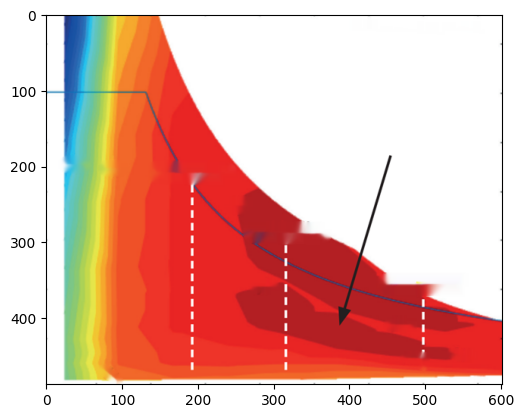

In [17]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)
    
em = infill_text(ID)
plt.imshow(em)

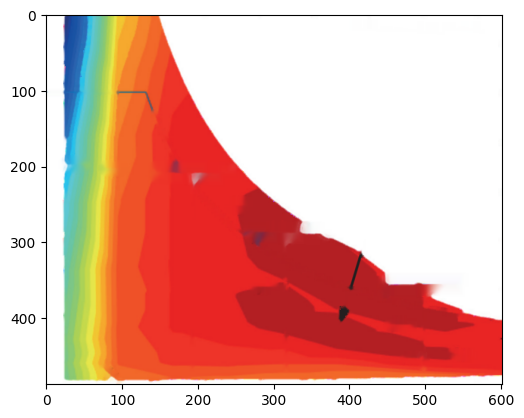

In [66]:
# remove lines

# Convert the image to grayscale
gray = cv2.cvtColor(em, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection with appropriate thresholds
edges = cv2.Canny(gray, 50, 150)

# Create a mask by dilating the edges
kernel = np.ones((5, 5), np.uint8)
mask = cv2.dilate(edges, kernel, iterations=1)

# Inpaint using the mask
inpaint = cv2.inpaint(em, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

plt.imshow(inpaint)

In [ ]:
## notes
# make initial cropping etc part of a ui tool
# use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to grayscale instead of PIL